# 04 - Applied ML

## Deadline
Tuesday November 22, 2016 at 11:59PM

## Background
In this homework we will gain experience on Applied Machine Learning, exploring an interesting dataset about soccer players and referees.
You can find all the data in the `CrowdstormingDataJuly1st.csv` file, while you can read a thorough [dataset description here](DATA.md).
Given that the focus of this homework is Machine Learning, I recommend you to first take a look at [this notebook](http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb)
containing a solid work in pre-processing + visualization of the given dataset. You are *not* allowed to just copy/paste the pre-processing steps
performed by the notebook authors -- you are still supposed to perform your own data analysis for the homework. Still, I'm confident that consulting first
the work done by expert data analysts will speed up tangibly your effort (i.e., they have already found for you many glitches in the data :)


## Assignment
1. Train a `sklearn.ensemble.RandomForestClassifier` that given a soccer player description outputs his skin color. Show how different parameters 
passed to the Classifier affect the overfitting issue. Perform cross-validation to mitigate the overfitting of your model. Once you assessed your model,
inspect the `feature_importances_` attribute and discuss the obtained results. With different assumptions on the data (e.g., dropping certain features even
before feeding them to the classifier), can you obtain a substantially different `feature_importances_` attribute?

  *BONUS*: plot the learning curves against at least 2 different sets of parameters passed to your Random Forest. To obtain smooth curves, partition
your data in at least 20 folds. Can you find a set of parameters that leads to high bias, and one which does not?

2. Aggregate the referee information grouping by soccer player, and use an unsupervised learning technique to cluster the soccer players in 2 disjoint
clusters. Remove features iteratively, and at each step perform again the clustering and compute the silhouette score -- can you find a configuration of features with high silhouette
score where players with dark and light skin colors belong to different clusters? Discuss the obtained results.


----

# Data Description

From a company for sports statistics, we obtained data and profile photos from all soccer players (N = 2053) playing in the first male divisions of England, Germany, France and Spain in the 2012-2013 season and all referees (N = 3147) that these players played under in their professional career. We created a dataset of player–referee dyads including the number of matches players and referees encountered each other and our dependent variable, the number of red cards given to a player by a particular referee throughout all matches the two encountered each other.
 
Player photos were available from the source for 1586 out of 2053 players. Players’ skin tone was coded by two independent raters blind to the research question who, based on their profile photo, categorized players on a 5-point scale ranging from “very light skin” to “very dark skin” with “neither dark nor light skin” as the center value. 

Additionally, implicit bias scores for each referee country were calculated using a race implicit association test (IAT), with higher values corresponding to faster white | good, black | bad associations. Explicit bias scores for each referee country were calculated using a racial thermometer task, with higher values corresponding to greater feelings of warmth toward whites versus blacks. Both these measures were created by aggregating data from many online users in referee countries taking these tests on [Project Implicit](http://projectimplicit.net).

In all, the dataset has a total of 146028 dyads of players and referees. A detailed description of all variables in the dataset can be seen in the list below.

## Variables:

*playerShort* - short player ID

*player* - player name

*club* - player club

*leagueCountry* - country of player club (England, Germany, France, and Spain)

*birthday* - player birthday

*height* - player height (in cm)

*weight* - player weight (in kg)

*position* - detailed player position

*games* - number of games in the player-referee dyad

*victories* - victories in the player-referee dyad

*ties* - ties in the player-referee dyad

*defeats* - losses in the player-referee dyad

*goals* - goals scored by a player in the player-referee dyad

*yellowCards* - number of yellow cards player received from referee

*yellowReds* - number of yellow-red cards player received from referee

*redCards* - number of red cards player received from referee

*photoID* - ID of player photo (if available)

*rater1* - skin rating of photo by rater 1 (5-point scale ranging from “very light skin” to “very dark skin”)

*rater2* - skin rating of photo by rater 2 (5-point scale ranging from “very light skin” to “very dark skin”)

*refNum* - unique referee ID number (referee name removed for anonymizing purposes)

*refCountry* - unique referee country ID number (country name removed for anonymizing purposes)

*meanIAT* - mean implicit bias score (using the race IAT) for referee country, higher values correspond to faster white | good, black | bad associations

*nIAT* - sample size for race IAT in that particular country

*seIAT* - standard error for mean estimate of race IAT

*meanExp* - mean explicit bias score (using a racial thermometer task) for referee country, higher values correspond to greater feelings of warmth toward whites versus blacks

*nExp* - sample size for explicit bias in that particular country

*seExp* - standard error for mean estimate of explicit bias measure


---
# 1. Random Forest Classifier

We want to train a `RandomForestClassifier` to predict a player's skin color based on the player's description.

In [ ]:
# Import stuff
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

### 1.1 Loading the data

The first step is of course to load the data provided to us in `CrowdstormingDataJuly1st.csv`. Its fields are described above for reference.

In [125]:
filename='CrowdstormingDataJuly1st.csv'
df = pd.read_csv(filename)
df.sample(10)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
11930,siqueira,Siqueira,Granada CF,Spain,28.04.1986,184.0,76.0,Left Midfielder,1,1,...,0.00,265,48,ITA,0.386174,1761.0,0.000232,0.529815,1895.0,0.001091
67667,sam-mantom,Sam Mantom,Walsall FC,England,20.02.1992,175.0,70.0,Center Midfielder,1,0,...,NaN,1439,111,ISL,0.378581,332.0,0.001191,0.531609,348.0,0.004260
97029,vieirinha,Vieirinha,VfL Wolfsburg,Germany,24.01.1986,173.0,73.0,Right Midfielder,2,2,...,0.00,2077,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
39673,francois-clerc,François Clerc,AS Saint-Étienne,France,18.04.1983,186.0,77.0,Right Fullback,1,1,...,0.00,737,48,ITA,0.386174,1761.0,0.000232,0.529815,1895.0,0.001091
133074,salomon-kalou,Salomon Kalou,Lille OSC,France,05.08.1985,184.0,77.0,Left Winger,1,0,...,0.75,2822,44,ENGL,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037
8079,bryan-ruiz,Bryan Ruiz,Fulham FC,England,18.08.1985,186.0,70.0,Right Winger,6,2,...,0.25,194,44,ENGL,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037
119614,gibril-sankoh,Gibril Sankoh,FC Augsburg,Germany,15.05.1983,186.0,80.0,Center Back,1,1,...,1.00,2539,8,DEU,0.336628,7749.0,0.000055,0.335967,7974.0,0.000225
49344,axel-ngando,Axel N'Gando,Stade Rennes,France,13.07.1993,177.0,67.0,Attacking Midfielder,1,0,...,NaN,941,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
67718,sotirios-kyrgiakos,Sotirios Kyrgiakos,VfL Wolfsburg,Germany,23.07.1979,193.0,88.0,Center Back,4,3,...,0.25,1449,45,SCOT,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037
83157,cristian-spunaru,Cristian Săpunaru,Real Zaragoza,Spain,05.04.1984,187.0,81.0,Right Fullback,4,2,...,0.25,1813,72,PRT,0.396803,1079.0,0.000392,0.790366,1121.0,0.001798


### 1.2 Cleaning the data

A few things have to be done to clean the data before we feed it to the classifier.

Firstly, let's merge the two skin color ratings into a mean one, since this score will act as our label for the classifier, and remove the two rating columns.

In [126]:
df['skintone']= (df['rater1']+df['rater2']) / 2
df = df.drop('rater1', 1)
df = df.drop('rater2', 1)

Secondly, let's remove players who don't have this rating since we won't be able to train the classifier with these examples. They are currently store as `NaN` scpre in the `skintone` column.

In [127]:
clean_df = df.copy()
clean_df = clean_df.dropna(axis = 0, subset = ['skintone'])

print("We kept {} of {} entries (delta = {}).".format(len(clean_df), len(df), len(df) - len(clean_df)))

We kept 124621 of 146028 entries (delta = 21407).


Let's now check for other missing values :

In [128]:
for column in clean_df:
    print(column + ':', len(clean_df[column].iloc[clean_df[column].isnull().nonzero()]))

playerShort: 0
player: 0
club: 0
leagueCountry: 0
birthday: 0
height: 46
weight: 753
position: 8461
games: 0
victories: 0
ties: 0
defeats: 0
goals: 0
yellowCards: 0
yellowReds: 0
redCards: 0
photoID: 0
refNum: 0
refCountry: 0
Alpha_3: 1
meanIAT: 153
nIAT: 153
seIAT: 153
meanExp: 153
nExp: 153
seExp: 153
skintone: 0


Let's first try to recover some of the missing information:

In [129]:
clean_df = clean_df.reset_index()

idx_weight = clean_df.iloc[clean_df['weight'].isnull().nonzero()].index
idx_height = clean_df.iloc[clean_df['height'].isnull().nonzero()].index

# Recover missing player weights, by taking the average weight of player with similar height and skintone
for idx in idx_weight:
    mean_weight = clean_df['weight'][
        (clean_df['height'] == clean_df.iloc[idx].height) &  
        (clean_df['skintone'] == clean_df.iloc[idx].skintone)
    ].mean() 

    clean_df.set_value(idx, 'weight', mean_weight)

# Recover missing player weights, by taking the average weight of player with similar weight and skintone
for idx in idx_height:
    mean_height = clean_df['height'][
        (clean_df['weight'] == clean_df.iloc[idx].height) &  
         (clean_df['skintone'] == clean_df.iloc[idx].skintone)
    ].mean() 

    clean_df.set_value(idx, 'height', mean_weight)

Harder, let's see if we can recover missing positions from the average number of goals a player scored:

In [130]:
players_no_pos = clean_df[['playerShort','goals']].iloc[clean_df['position'].isnull().nonzero()]
mean_goals_per_pos = clean_df[['position', 'goals']].groupby(['position']).mean()['goals'].to_dict()
players_mean_goals = players_no_pos.groupby('playerShort').mean()

# Compute player position label from the average number of goals a player scored:
def compute_pos(row, axis=None):
    goals = players_mean_goals[players_mean_goals.index == row['playerShort']].goals.any()
    diff = [(abs(goals - mean_goals_per_pos[pos]), pos) for pos in mean_goals_per_pos]
    diff.sort(key=lambda x: x[0])
    return diff[0][1]

idx = clean_df.iloc[clean_df['position'].isnull().nonzero()].index
for i in idx:
    pos = compute_pos(clean_df.iloc[i])
    clean_df.set_value(i,'position',compute_pos(clean_df.iloc[i]))
    
clean_df['goals'].iloc[clean_df['position'].isnull().nonzero()]

Series([], Name: goals, dtype: int64)

In [131]:
to_drop = [
    'player', 'photoID', 'birthday',
    'refNum', 'meanIAT', 'nIAT', 'seIAT',
    'nExp', 'seExp', 'refCountry', 'meanExp',
    'index'
]

final_df = clean_df.drop(to_drop, axis=1).dropna().groupby('playerShort').agg('first')

This leaves us with our final dataset:

In [132]:
print("There are {} individual player entries.".format(len(final_df)))

There are 1582 individual player entries.


We can now extract the labels that will be used to train the classifier. We will use the `LabelEncoder` to get labels usable by sklearn.

In [133]:
labels = np.array(final_df['skintone'])

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

We'll start by using all the features provided by the dataset to train the classifier, later figuring out which ones are actually interesting. Once again we will transform the entries into values that are processable by sklearn, using `LabelEncoder`.

In [134]:
features = final_df.drop('skintone', 1)

encoders = {}
for col in features.columns.values:
    le = LabelEncoder()
    features[col] = le.fit_transform(pd.factorize(features[col])[0])    

### 1.3 Training the classifier

We've now got our training data so let's try to train the `RandomForestClassifier`.

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X_clf = features
Y_clf = labels

def run_random_forest(X,Y):
    # Split into a test and a train set
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

    # Create the RandomForestClassifier
    forest = RandomForestClassifier(n_jobs=4)

    # Train the model
    clf_tmp = forest.fit(X_train, y_train)
    
    test_score = clf_tmp.score(X_test, y_test)
    train_score = clf_tmp.score(X_train, y_train)
    
    print("Score: \n   -  test : {} \n   -  train : {}\n".format(test_score, train_score))
    
    scores = cross_val_score(clf_tmp, X_test, y_test, cv=5)
    print("Accuracy:\n   %0.6f (+/- %0.6f)" % (scores.mean(), scores.std() * 2))
    
    return clf_tmp

clf = run_random_forest(X_clf,Y_clf)

Score: 
   -  test : 0.27330173775671407 
   -  train : 0.9841938883034773

Accuracy:
   0.242935 (+/- 0.060715)


### 1.4 Learning Curves

We want to see how our model's accuracy evolves with the number of samples. For this we can plot a learning curve, which will randomly split the data into test and training sets using a `ShuffleSplit`. It will then train the model and compute its score over the test set. We can then plot the accuracy over the number of training examples.

In [136]:
# Plot code adapted from :
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
#
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def learning_curve_plot(clf, X, Y):
    # Legends
    title  = "Learning Curves (Random Forest Classifier)"
    xlabel = "Training examples"
    ylabel = "Score"

    # Plots params
    y_lim = (0.0, 1.01)

    # CV params
    train_sizes = np.linspace(.01, 1.0, 10)
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

    plt.figure()
    plt.title(title)
    plt.ylim(*y_lim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    train_sizes, train_scores, test_scores = learning_curve(clf, X, Y, cv=cv, n_jobs=4, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores , axis=1)

    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_std   = np.std(test_scores , axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")

    plt.show()

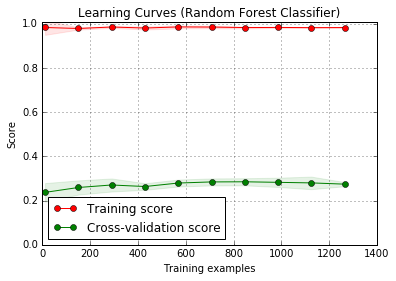

In [137]:
learning_curve_plot(clf, X_clf, Y_clf)

As we can see (and might have guessed from our accuracy scores), our model has a very good score on the training set but does not generalize well : the test score is quite low (30%). In order to adress this we will do some cross-validation on our classifier's parameters. The main parameters to adjust when using these methods is `n_estimators` and `max_features`.

In [ ]:
from sklearn.model_selection import cross_val_score

n_estimators_range = range(1, 500, 50)

scores = list()
scores_std = list()

# Split into a test and a train set
X_train, X_test, Y_train, Y_test = train_test_split(X_clf, Y_clf, test_size=0.4, random_state=42)

for n_estimators in n_estimators_range:
    f = RandomForestClassifier(n_estimators=n_estimators, n_jobs=4)
    clf_tmp = f.fit(X_train, Y_train)
    this_scores = cross_val_score(clf, X_clf, Y_clf)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

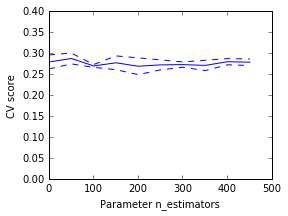

In [109]:
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.plot(n_estimators_range, scores)
plt.plot(n_estimators_range, np.array(scores) + np.array(scores_std), 'b--')
plt.plot(n_estimators_range, np.array(scores) - np.array(scores_std), 'b--')
plt.ylabel('CV score')
plt.xlabel('Parameter n_estimators')
plt.ylim(0, 0.4)
plt.show()

As we can see here the CV score stays around 30% for any `n_estimators` > 50. This means we might have another issue : the features do not hold enough information or their subset was not chosen correctly. Let's study this aspect next.

### 1.5 Feature importances

We would like to figure out which of the features are the most relevant to our model (i.e. the features that represent the most variance / information). These are the features that help the classifier make its decision.

We have access to this information in `RandomForestClassifier.feature_importances_`, so we can plot their importance.

In [110]:
def feature_importances_plot(clf, X, Y):
    # Plot code adapted from :
    # http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py
    #
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    feature_names = X.columns.values.tolist()

    # Print the feature ranking
    print("Feature ranking:")

    for j in range(X_train.shape[1]):
        print("%d. feature #%d %s (%f)" % (j + 1, indices[j], feature_names[indices[j]], importances[indices[j]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

Feature ranking:
1. feature #0 club (0.157338)
2. feature #3 weight (0.143964)
3. feature #2 height (0.143342)
4. feature #4 position (0.109719)
5. feature #13 Alpha_3 (0.107456)
6. feature #1 leagueCountry (0.058811)
7. feature #5 games (0.058291)
8. feature #6 victories (0.055227)
9. feature #8 defeats (0.050589)
10. feature #7 ties (0.044594)
11. feature #10 yellowCards (0.035491)
12. feature #9 goals (0.029212)
13. feature #11 yellowReds (0.003097)
14. feature #12 redCards (0.002868)


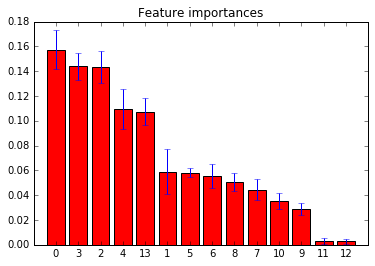

In [111]:
feature_importances_plot(clf, X_clf, Y_clf)

It is interesting to note that `yellowReds` and `redCards` seem to not have any impact.

On the other hand there are notably 5 features that seem to be more important than the rest :
* club
* height
* weight
* position
* Alpha_3

Let's create a powerset (i.e. all possible cominbations of the 5) of these features and see which combinations give good results.

In [112]:
from itertools import combinations

# Compute the powerset of the given list
def powerset(l):
    combs = []
    for i in range(0, len(l) + 1):
        listing = [list(x) for x in combinations(l, i)]
        combs.extend(listing)
    return combs

In [113]:
good_features = ['club', 'height' ,'weight', 'position', 'Alpha_3']
feature_subsets = list(powerset(good_features))

subset_scores = list()
subset_scores_std = list()

feature_subsets = [x for x in feature_subsets if x != []]

for subset in feature_subsets:
    # Split into a test and a train set
    X_train, X_test, Y_train, Y_test = train_test_split(X_clf[subset], Y_clf, test_size=0.4, random_state=42)
    f = RandomForestClassifier(n_estimators=n_estimators)
    clf_tmp = f.fit(X_train, Y_train)
    this_scores = cross_val_score(clf_tmp, X_clf[subset], Y_clf)
    subset_scores.append(np.mean(this_scores))
    subset_scores_std.append(np.std(this_scores))

In [114]:
feature_subsets = [x for x in feature_subsets if x != []]
scores_df = pd.DataFrame({ 'subset' : feature_subsets, 'score' : subset_scores, 'std' : subset_scores_std })
scores_df.sort_values(['score'], ascending = False).reset_index()

,index,score,std,subset
0,0,0.312331,0.015304,[club]
1,28,0.303374,0.012256,"[club, weight, position, Alpha_3]"
2,4,0.301533,0.003870,[Alpha_3]
3,3,0.291377,0.005622,[position]
4,30,0.290750,0.006860,"[club, height, weight, position, Alpha_3]"
5,1,0.283777,0.008755,[height]
6,25,0.282570,0.006728,"[club, height, weight, position]"
7,26,0.281319,0.011026,"[club, height, weight, Alpha_3]"
8,2,0.280669,0.002626,[weight]
9,14,0.273693,0.007431,"[position, Alpha_3]"


As we can see the combinations don't bring better results, with a maximum accuracy of 30%.

### 1.6 Binary Classification

Another idea is to treat this problem as a binary classification problem : instead of the 6 labels for the skintone, let's arbitrarily divide the labels into 2 classes and see if we can achieve better results.

Score: 
   -  test : 0.8499210110584519 
   -  train : 0.9799789251844047

Accuracy:
   0.845232 (+/- 0.028228)


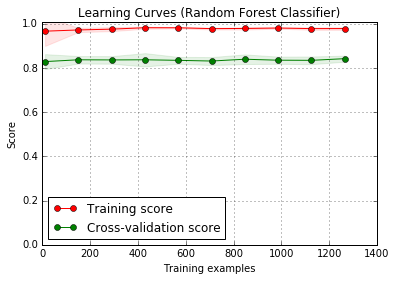

In [116]:
def binary_skintone(tone):
    return 1 if tone > 0.5 else 0 

X_bin = X_clf
Y_bin = np.array(final_df['skintone'].apply(binary_skintone))

clf_bin = run_random_forest(X_bin, Y_bin)
learning_curve_plot(clf_bin, X_bin, Y_bin)

As we can see, the binary classifier is much more accurate, but we need to keep in mind that it's easier to classify into two classes versus the six we had before.

---
# 2. Player Clustering

First, some imports, and utilities:

In [117]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy           import stats

from itertools import combinations
from copy      import copy

# Compute the powerset of the given list
def powerset(l):
    combs = []
    for i in range(0, len(l) + 1):
        listing = [list(x) for x in combinations(l, i)]
        combs.extend(listing)
    return combs

Here's the list of all features from the dataset, mostly present here as a reference for us, as we copy-pasted them from `df.columns.values`'s output

In [118]:
all_features = [
    'player', 'photoID', 'birthday', 'games',
    'refNum', 'refCountry', 'victories', 'ties', 'defeats',
    'club', 'height', 'Alpha_3',
    'leagueCountry', 'weight', 'position',
    'nExp', 'seExp',
    'nIAT', 'seIAT',
    'meanExp', 'meanIAT',
    'yellowCards', 'yellowReds', 'redCards',
]

All uncommented features in the list below will be taken into
account when computing the various features subsets before running KMeans.
We only picked features that had something to do with referee decisions, and not ones about the players themselves, or the game results.

In [119]:
features_map = {
    # 'player'        : 'first',
    # 'club'          : 'first',
    #'leagueCountry' : 'first',
    # 'birthday'      : 'first',
    #'height'        : 'first',
    #'weight'        : 'first',
    #'position'      : 'first',
    # 'games'         : 'sum',
    # 'victories'     : 'sum',
    # 'ties'          : 'sum',
    # 'defeats'       : 'sum',
    # 'goals'         : 'sum',
    'yellowCards'   : 'sum',
    'yellowReds'    : 'sum',
    'redCards'      : 'sum',
    # 'photoID'       : 'first',
    # 'refNum'        : 'first',
    'refCountry'    : 'first',
    #'Alpha_3'       : 'first',
    'meanIAT'       : 'mean',
    #'nIAT'          : 'mean',
    #'seIAT'         : 'mean',
    'meanExp'       : 'mean',
    #'nExp'          : 'mean',
    #'seExp'         : 'mean',
    #'skintone': 'mean'
}

Here's the meat of the algorithm, described in detail in the code below:

In [120]:
#
# Run K-Means on DataFrame df with the given features.
# 
# @param df the DataFrame to run K-Means on
# @param features a subset of the `features_map` defined above
#
def run_kmeans(df, features_kept):

    # We first compute the columns we need to drop from the DataFrame (ie. the ones not in `features_kept`)
    to_drop = [feature for feature in all_features if feature not in features_kept]
    
    # We don't want to include the 'skintone' feature in K-Means but still need to keep it
    # around so that we can see how much it is going to vary between the two clusters.
    agg = copy(features_kept)
    agg['skintone'] = 'mean'

    # We now drop those features, drop all rows with N/A values, and group them by player,
    # aggregating the remaining columns with the aggregator function defined in the map above.
    cluster_df = df.drop(to_drop, axis=1).dropna().groupby('playerShort').agg(agg)

    # We now encode all non-numerical values (if any).
    # These are denoted by their aggregator being 'first' in the map above.
    for col in cluster_df.columns.values:
        if agg[col] != 'first':
            continue
            
        le = LabelEncoder()
        labels = le.fit_transform(cluster_df[col])
        cluster_df[col] = labels
        # encoders[col] = le

    # Initialize K-Means with sensible parameters
    kmeans = KMeans(n_clusters=2, max_iter=100, n_init=5, n_jobs=4, random_state=42)

    # We now drop the skintone and the player shortname from the dataset,
    # as the former should not be included, while the latter is unique to a player
    # and won't yield any interesting information.
    dataset = cluster_df.reset_index().drop(['skintone', 'playerShort'], axis=1)

    # Let's see in which cluster each row landed
    dist = kmeans.fit_predict(dataset)

    # Put the cluster number of each row in a DataFrame...
    cluster_num_df = pd.DataFrame(dist, columns=['cluster'])

    # ... that we then join with the original DataFrame containing the player name and skintone.
    with_cluster = cluster_df.reset_index().join(cluster_num_df)

    # Compute the silhouette score for that clustering
    sil_score = silhouette_score(dataset, dist)
    
    # Split the DataFrame per cluster
    cluster_0 = with_cluster[with_cluster['cluster'] == 0]
    cluster_1 = with_cluster[with_cluster['cluster'] == 1]
    
    # Get the skintones from each cluster
    skintone_0 = cluster_0['skintone']
    skintone_1 = cluster_1['skintone']
    
    # Compute the difference in skintone variance between the two clusters
    delta_variance = abs(skintone_0.var() - skintone_1.var())

    # Perform a T-test over the skintone distributions of the two clusters
    (t_statistic, p_value) = stats.ttest_ind(skintone_0, skintone_1, equal_var = delta_variance < 1e-6)

    # Store the result for further processing
    return {
        'score': sil_score,
        'features': list(features_kept.keys()),
        'skintone_diff': skintone_0.mean() - skintone_1.mean(),
        'cluster_0_skintone': skintone_0.mean(),
        'cluster_1_skintone': skintone_1.mean(),
        'p_value': p_value,
        'diff_is_stat_sign': p_value < 0.05,
        'data': with_cluster
    }

Let's run the algorithm above on all possible subsets of features, amongst the ones we chose to consider above:

In [123]:
clean_df

,club,leagueCountry,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,Alpha_3,skintone
playerShort,,,,,,,,,,,,,,,
aaron-hughes,Fulham FC,England,182.0,71.000000,Center Back,1,0,0,1,0,0,0,0,LUX,0.125
aaron-hunt,Werder Bremen,Germany,183.0,73.000000,Attacking Midfielder,2,0,0,2,0,0,0,0,LUX,0.125
aaron-lennon,Tottenham Hotspur,England,165.0,63.000000,Right Midfielder,2,1,0,1,0,0,0,0,LUX,0.250
aaron-ramsey,Arsenal FC,England,178.0,76.000000,Center Midfielder,2,2,0,0,0,0,0,0,LUX,0.000
abdelhamid-el-kaoutari,Montpellier HSC,France,180.0,73.000000,Center Back,6,2,2,2,0,0,0,0,FRA,0.250
abdou-traore_2,Girondins Bordeaux,France,180.0,74.000000,Right Midfielder,1,0,0,1,0,0,0,0,ESP,0.750
abdoulaye-diallo_2,Stade Rennes,France,189.0,80.000000,Goalkeeper,1,1,0,0,0,0,0,0,FRA,0.875
abdoulaye-keita_2,Girondins Bordeaux,France,188.0,83.000000,Goalkeeper,2,0,0,2,0,0,0,0,FRA,0.875
abdoulwhaid-sissoko,Stade Brest,France,180.0,68.000000,Defensive Midfielder,3,1,0,2,0,0,0,0,FRA,1.000


In [122]:
results = []

# Compute the powerset of all the features we want to consider
all_subsets = list(powerset(features_map.keys()))

def binary_skintone(x, axis=None):
    return int(x['skintone'])

clean_df2 = clean_df.copy()
clean_df2['skintone'] = clean_df.apply(binary_skintone, axis=1)

# Run K-Means on each non-empty subset
for subset in all_subsets:
    if len(subset) == 0:
        continue
        
    agg = {}
    for feature in subset:
        agg[feature] = features_map[feature]
        
    result = run_kmeans(clean_df2, agg)
    results.append(result)
    print('Features: {}\n - Score: {}\n - P-value: {}\n'.format(result['features'], result['score'], result['p_value']))

ValueError: labels ['player' 'photoID' 'birthday' 'refNum' 'nExp' 'seExp' 'nIAT' 'seIAT'
 'meanExp' 'meanIAT'] not contained in axis

We now only keep the results for which the difference between the mean skintone of each cluster is statistically significant, and plot the silhouette score:

In [6]:
results_df = pd.DataFrame(results, columns=['score', 'features', 'skintone_diff', 'cluster_0_skintone', 'cluster_1_skintone', 'diff_is_stat_sign'])
results_df = results_df[results_df['diff_is_stat_sign'] == True]
results_df[['score', 'features']].sort_values(['score']).set_index('features').plot(kind='bar')

NameError: name 'pd' is not defined

Let's take a look at the results themselves as well:

In [ ]:
results_df.sort_values('score', ascending=False)

There does seem to be indeed a difference in skintone between the two clusters when we cluster by the mean value of either of the racism indicators. But as these features only appear by themselves, we cannot conclude anything other than these indicators have a slight influence on the overall number of decisions taken by referee given the player's skintone.

Overall it seems there is no racial bias in the referees' decisions, at least those that involve a card of either color.